In [1]:
#text clustering
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
df = pd.read_csv('/content/drive/My Drive/edited_all_news.csv')
df.head()

,Unnamed: 0,_id,topic,heading,content,tags,processed_content,processed_topic
0,0,5f04d2481f35ed6864839349,"[""West-bengal""]","[""\n "",""\n ...","[""Garbage-lined streets and overflowing drains...","[""Garbage"",""Salt-lake"",""Bidhannagar-municipal-...",garbag line street overflow drain salt lake sp...,west bengal
1,1,5f04d24b1f35ed686483934a,"[""West-bengal""]","[""\n "",""\n ...","[""The Bengal government will set up a plasma b...","[""Calcutta-medical-college-and-hospital"",""Coro...",bengal govern plasma bank calcutta medic colle...,west bengal
2,2,5f04d24d1f35ed686483934b,"[""West-bengal""]","[""\n "",""\n ...","[""Bengal set another 24-hour record on Monday ...","[""Lockdown"",""Coronavirus"",""Quarantine""]",bengal hour record monday highest number covid...,west bengal
3,3,5f04d2501f35ed686483934c,"[""West-bengal""]","[""\n "",""\n ...","[""Chief minister Mamata Banerjee on Monday sai...","[""Mamata-banerjee"",""Cyclone-amphan""]",chief minist mamata banerje monday say problem...,west bengal
4,4,5f04d2531f35ed686483934d,"[""West-bengal""]","[""\n "",""\n ...","[""Some senior historians have raised questions...","[""Jagat-prakash-nadda"",""Bharatiya-janata-party...",senior historian rais question attempt pitch b...,west bengal


In [5]:
df.shape

(1274, 8)

In [30]:
df.processed_topic.nunique()

50

In [3]:
df.isnull().sum()

Unnamed: 0             0
_id                    0
topic                  0
heading              383
content                0
tags                  68
processed_content      0
processed_topic       30
dtype: int64

In [4]:
df.dropna(subset = ['processed_topic'], inplace = True)

In [6]:
#feature extraction
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.processed_content.values)
features = vec.transform(df.processed_content.values)

In [34]:
#model training
random_state = 0
cls = MiniBatchKMeans(n_clusters=32, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=32, n_init=3, random_state=0,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [35]:
#predict on new data
cls.predict(features)

array([ 2, 13, 17, ...,  2,  2,  2], dtype=int32)

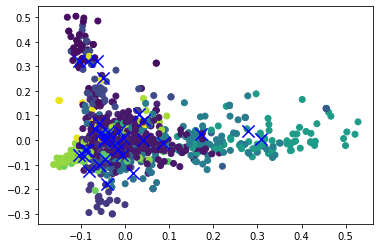

In [36]:
#visualization
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [37]:
#evaluation with labelled dataset
from sklearn.metrics import homogeneity_score
homogeneity_score(df.processed_content, cls.predict(features))

0.31693759400994326

In [38]:
#evaluation with unlabelled dataset
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

0.02109898188841042

In [39]:
#more on accuracy scores

#actual labels
actual_labels = np.unique(df.processed_topic, return_inverse=True)[1]
#pd.factorize(df.processed_topic)[0]

In [40]:
cls.labels_

array([ 2, 13, 17, ...,  2,  2,  2], dtype=int32)

In [41]:
actual_labels

array([48, 48, 48, ..., 29, 29, 29])

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(cls.labels_, actual_labels)

0.05337519623233909

In [46]:
#import seaborn as sns
#sns.set()
#from sklearn.metrics import confusion_matrix
#mat = confusion_matrix(cls.labels_, actual_labels)
#sns.heatmap(mat.T, annot=True, fmt='d', cmap = 'Blues')
#plt.xlabel('true label')
#plt.ylabel('predicted label')

In [47]:
#from sklearn.metrics import classification_report
#classification_report(actual_labels, cls.labels_) 

In [43]:
from sklearn.metrics import precision_score
precision_score(actual_labels, cls.labels_,  average='micro')

0.05337519623233909

In [44]:
from sklearn.metrics import recall_score
recall_score(actual_labels, cls.labels_, average='micro')

0.05337519623233909

In [45]:
#topic modelling
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

random_state = 0

def only_nouns(texts):
    output = []
    for doc in nlp.pipe(texts):
        noun_text = " ".join(token.lemma_ for token in doc if token.pos_ == 'NOUN')
        output.append(noun_text)
    return output


df['noun_content'] = only_nouns(df['content'])

df.head()

,Unnamed: 0,_id,topic,heading,content,tags,processed_content,processed_topic,noun_content
0,0,5f04d2481f35ed6864839349,"[""West-bengal""]","[""\n "",""\n ...","[""Garbage-lined streets and overflowing drains...","[""Garbage"",""Salt-lake"",""Bidhannagar-municipal-...",garbag line street overflow drain salt lake sp...,west bengal,garbage street drain fear outbreak disease res...
1,1,5f04d24b1f35ed686483934a,"[""West-bengal""]","[""\n "",""\n ...","[""The Bengal government will set up a plasma b...","[""Calcutta-medical-college-and-hospital"",""Coro...",bengal govern plasma bank calcutta medic colle...,west bengal,government plasma bank trial plasma therapy co...
2,2,5f04d24d1f35ed686483934b,"[""West-bengal""]","[""\n "",""\n ...","[""Bengal set another 24-hour record on Monday ...","[""Lockdown"",""Coronavirus"",""Quarantine""]",bengal hour record monday highest number covid...,west bengal,record number toll people toll state infection...
3,3,5f04d2501f35ed686483934c,"[""West-bengal""]","[""\n "",""\n ...","[""Chief minister Mamata Banerjee on Monday sai...","[""Mamata-banerjee"",""Cyclone-amphan""]",chief minist mamata banerje monday say problem...,west bengal,minister problem mistake aid government victim...
4,4,5f04d2531f35ed686483934d,"[""West-bengal""]","[""\n "",""\n ...","[""Some senior historians have raised questions...","[""Jagat-prakash-nadda"",""Bharatiya-janata-party...",senior historian rais question attempt pitch b...,west bengal,historian question attempt founder creator pro...


In [48]:
# change this to see different results using the components_ attribute
n_topics = 32

#for extracting features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer(max_features=5000, stop_words="english", max_df=0.95, min_df=2)
features = vec.fit_transform(df.noun_content)

#for topic modelling

from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=32, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [49]:
# list of unique words found by the vectorizer
feature_names = vec.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 15

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    # topic_vec.argsort() produces a new array
    # in which word_index with the least score is the
    # first array element and word_index with highest
    # score is the last array element. Then using a
    # fancy indexing [-1: -n_top_words-1:-1], we are
    # slicing the array from its end in such a way that
    # top `n_top_words` word_index with highest scores
    # are returned in desceding order
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 case death number state tally day toll rate sample infection fatality recovery people country hour 
1 film actress director story role release character script shoot scene movie award work actor action 
2 student exam university class semester course college curriculum visa syllabus immigration country decision assessment examination 
3 police encounter policeman murder station gangster officer personnel investigation house killing militant violence inspector car 
4 company employee flight service investment firm revenue business stake family market technology share executive client 
5 team player match game club season captain title league win cricket year football tournament goal 
6 app user platform application phone feature device security technology datum video news camera content review 
7 cent price oil sector market lakh crore barrel recovery datum gdp dollar rate point currency 
8 patient hospital doctor treatment plasma bed oxygen facility drug health ward isolation managem

In [50]:
# to identify topic of a new document
new_articles = [
    '''The Chhattisgarh Board of Secondary Education (CGBSE) will announce the high school (Class 10), higher secondary (Class 12) and higher secondary vocational exam results on Tuesday, June 23. The Chhattisgarh Board results will be declared at 11am by school education minister.","In a press release issued on Monday, the Chhattisgarh Board said that keeping in mind the Covid-19 situation, the CGBSE 10th, 12th results will be declared through video conferencing at state data centre in Raipur. ","Students who have appeared for the Chhattisgarh Board Class 10 and Class 12 exams can their results at cgbse.nic.in, http://results.gov.in/cgresults and results.cg.nic.in after it is announced.","Around 6 lakh students have registered for CGBSE class 10th board exams this year, while over 2.5 lakh students have registered for CGBSE class 12th board exams 2020.","Due to the coronavirus disease outbreak, CGBSE could not conduct examinations for all the subjects of Class 10 and 12. The exams for some minor subjects of Class 10 and Geography and a few optional papers of Class 12 had to be delayed.","The students have been awarded marks in these subjects on the basis of internal assessment. Those failing to pass the assessment and skip the procedures will be given the minimum passing marks. Nobody will fail during the assessment of the remaining subjects ''',
    '''Jose Mourinho launched an impassioned defence of Harry Kaneâ€™s form under his playing style at Tottenham Hotspur after television pundit Paul Merson suggested the England striker would struggle in the Portuguese managerâ€™s system.","Merson, a pundit with Sky Sports, said 26-year-old Kane would consider switching clubs if Mourinho continued adopting a conservative style in the Premier League, like they did in their 1-1 draw with Manchester United last week.","Kane has scored seven goals in 10 games under Mourinho but struggled to make an impact against United -- his first match since returning from a hamstring surgery in January -- and Mourinho said Merson was wrong to judge him based on one game.","â€œThe record of goals that Harry has with me (in charge) is easy for you to see ... I can say I had a few strikers who played for me and they are not bad,â€ Mourinho told reporters in a virtual news conference on Monday.","In a five-minute-long response, Mourinho then went on to mention the likes of Didier Drogba, Cristiano Ronaldo, Karim Benzema, Diego Milito and Zlatan Ibrahimovic, reeling off their goal scoring stats under his tenures at various clubs.","â€œSo dear Paul, I have lots of respect for you,â€ Mourinho added. â€œI think Harry Kane has no problems at all to score goals in my teams, especially when heâ€™s fit, when heâ€™s fresh and he has routines of playing.â€","There was good news on the injury front for Mourinho who confirmed forward Lucas Moura was available after recovering from an injury while Dele Alli is also in contention after serving his one-match suspension.","â€œFor the first time since I arrived, all six attacking players are available for the game,â€ Mourinho said.","â€œIâ€™ve had matches with only one and now finally I have six so I can have people playing and on the bench to rotate players. Our attacking options for this match are really good.'''
]
# first transform the text into features using vec
# then pass it to transform of cls
# the result will be a matrix of shape [2, 10]
# then we sort the topic id based on the score using argsort
# and take the last one (with the highest score) for each row using `[:,-1]` indexing
cls.transform(vec.transform(new_articles)).argsort(axis=1)[:,-1]

array([14,  5])